In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def generate_signals_rank(df_predictions, top_quantile=0.3, bottom_quantile=0.3,rolling_window = 1):
    """
    Generates buy and sell signals based on ranking.
    
    Args:
    - df_predictions (pd.DataFrame): DataFrame with predictions.
    - top_quantile (float): Top quantile for buy signals.
    - bottom_quantile (float): Bottom quantile for sell signals.
    
    Returns:
    - pd.DataFrame: Signals DataFrame with buy (1), sell (-1), and hold (0) signals.
    """
    signals = df_predictions.copy().sort_values(by='date')    
    signals['prediction'] = signals.groupby('Ticker')['prediction'].transform(lambda x: x.rolling(window=rolling_window).mean())
    signals['signal'] = 0  # Default to hold
    for date in signals['date'].unique():
        date_mask = signals['date'] == date
        date_data = signals[date_mask]
        top_threshold = date_data['prediction'].quantile(1 - top_quantile)
        bottom_threshold = date_data['prediction'].quantile(bottom_quantile)
        signals.loc[date_mask & (date_data['prediction'] >= top_threshold), 'signal'] = 1  # Buy
        signals.loc[date_mask & (date_data['prediction'] <= bottom_threshold), 'signal'] = -1  # Sell
    return signals

def generate_signals_threshold(df_predictions, buy_threshold, sell_threshold,rolling_window = 1):
    """
    Generates buy and sell signals based on a threshold.
    
    Args:
    - df_predictions (pd.DataFrame): DataFrame with predictions.
    - buy_threshold (float): Threshold for buy signals.
    - sell_threshold (float): Threshold for sell signals.
    
    Returns:
    - pd.DataFrame: Signals DataFrame with buy (1), sell (-1), and hold (0) signals.
    """
    signals = df_predictions.copy().sort_values(by='date')    
    signals['prediction'] = signals.groupby('Ticker')['prediction'].transform(lambda x: x.rolling(window=rolling_window).mean())
    signals['signal'] = 0  # Default to hold
    signals.loc[signals['prediction'] >= buy_threshold, 'signal'] = 1  # Buy
    signals.loc[signals['prediction'] <= sell_threshold, 'signal'] = -1  # Sell
    return signals



In [3]:
def backtest_with_signals(df_signals, df_returns, initial_capital=100000, capital_proportion=1.0, trading_cost=0.0005,print_status = False):
    """
    Backtests a strategy based on signals and returns.

    Args:
    - df_signals (pd.DataFrame): DataFrame containing the signals for trades.
    - df_returns (pd.DataFrame): DataFrame containing actual returns.
    - initial_capital (float): The initial capital in the strategy.
    - capital_proportion (float): Proportion of capital to be invested.
    - trading_cost (float): The cost of making a trade as a proportion of the trade volume.

    Returns:
    - None: Displays a plot of cumulative returns and prints performance metrics.
    """
    # Merge signals with returns
    df_signals.rename(columns={'prediction': 'return'}, inplace=True)
    df_merged = pd.merge(df_signals, df_returns, on=['date', 'Ticker'], suffixes=('_pred', '_actual'))
    
    # Calculate signal changes (turnovers)
    df_merged.sort_values(by=['Ticker', 'date'], inplace=True)  # Ensure the data is sorted
    df_merged['signal_change'] = df_merged.groupby('Ticker')['signal'].diff().fillna(0) != 0
    
    # Calculate daily returns with trading cost applied only on signal change
    df_merged['trading_cost'] = np.abs(df_merged['signal_change']) * trading_cost
    df_merged['daily_return'] = df_merged['signal'] * df_merged['return_actual'] - df_merged['trading_cost']
    

    daily_portfolio_return = df_merged.groupby('date')['daily_return'].mean()  # Equal weight assumption

    # Adjust for capital proportion
    daily_portfolio_return *= capital_proportion

    # Calculate cumulative returns
    cumulative_returns = (daily_portfolio_return + 1).cumprod() * initial_capital
    
    # Annualized turnover
    turnover_daily = df_merged.groupby('date')['signal_change'].mean()
    annualized_turnover = turnover_daily.mean() * 252

    # Performance metrics
    # Performance metrics
    total_return = cumulative_returns.iloc[-1] / initial_capital - 1
    num_days = len(daily_portfolio_return)
    annualized_return = (total_return + 1) ** (252.0 / num_days) - 1
    daily_volatility = daily_portfolio_return.std()
    annualized_volatility = daily_volatility * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan
    max_drawdown = ((cumulative_returns.cummax() - cumulative_returns) / cumulative_returns.cummax()).max()

    if print_status:
        # Print metrics
        print(f"Total Return: {total_return:.2%}")
        print(f"Annualized Return: {annualized_return:.2%}")
        print(f"Annualized Volatility: {annualized_volatility:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
        print(f"Max Drawdown: {max_drawdown:.2%}")
        print(f"Annualized Turnover: {annualized_turnover:.2%}")
    
    return annualized_return,sharpe_ratio, max_drawdown, cumulative_returns

# Example usage (assuming df_signals and df_returns are defined):
# backtest_with_signals(df_signals, df_returns, capital_proportion=0.5)


In [4]:
def plot_rtn(cumulative_returns,title = 'Backtest Results'):
    # Plotting
    plt.figure(figsize=(10, 6))
    cumulative_returns.plot()
    plt.title(title)
    plt.ylabel('Portfolio Value')
    plt.xlabel('Date')
    plt.show()


In [44]:
def optimize_parameters(df_predictions, df_returns, rank_params, threshold_params, backtest_params):
    """
    Optimizes and finds the best parameter combinations for ranking and threshold signal methods
    based on Sharpe Ratio and Annualized Return from the backtested strategies.

    Args:
    - df_predictions (pd.DataFrame): DataFrame with predictions.
    - df_returns (pd.DataFrame): DataFrame with actual returns.
    - rank_params (dict): Parameter grid for the ranking method.
    - threshold_params (dict): Parameter grid for the threshold method.
    - backtest_params (dict): Parameters for backtesting.

    Returns:
    - A tuple containing lists of the top 3 parameter combinations based on Sharpe Ratio and Annualized Return.
    """
    results = []

    # Iterate over all parameter combinations for the ranking and threshold methods
    for method_params, method in [(rank_params, 'rank'), (threshold_params, 'threshold')]:
        for rolling_window in method_params['rolling_window']:
            for cap_prop in backtest_params['capital_proportion']:
                if method == 'rank':
                    for top_q in method_params['top_quantile']:
                        for bottom_q in method_params['bottom_quantile']:
                            signals = generate_signals_rank(df_predictions, top_quantile=top_q, bottom_quantile=bottom_q, rolling_window=rolling_window)
                            annualized_return, sharpe_ratio, _, _ = backtest_with_signals(signals, df_returns, capital_proportion=cap_prop)
                            results.append((method, top_q, bottom_q, rolling_window, cap_prop, 2*sharpe_ratio, 2*annualized_return))
                elif method == 'threshold':
                    for buy_t in method_params['buy_threshold']:
                        for sell_t in method_params['sell_threshold']:
                            signals = generate_signals_threshold(df_predictions, buy_threshold=buy_t, sell_threshold=sell_t, rolling_window=rolling_window)
                            annualized_return, sharpe_ratio, _, _ = backtest_with_signals(signals, df_returns, capital_proportion=cap_prop)
                            results.append((method, buy_t, sell_t, rolling_window, cap_prop, 2*sharpe_ratio, 2*annualized_return))

    # Sort results by Sharpe Ratio and Annualized Return
    top_by_sharpe = sorted(results, key=lambda x: x[5], reverse=True)[:3]
    top_by_annual_return = sorted(results, key=lambda x: x[6], reverse=True)[:3]

    return top_by_sharpe, top_by_annual_return


# GRU

In [38]:
tpphrm_return = pd.read_csv('tpphrm_return.csv', parse_dates=['date']).drop(
    columns=['Unnamed: 0'])

In [39]:
test_res_gru = pd.read_csv('predict data/test_res_2_4.csv', parse_dates=['date']).drop(
    columns=['Unnamed: 0']).rename(columns={'fac':'prediction','code':'Ticker'})
val_res_gru = pd.read_csv('predict data/val_res_2_4.csv', parse_dates=['date']).drop(
    columns=['Unnamed: 0']).rename(columns={'fac':'prediction','code':'Ticker'})

In [45]:
# parameter ranges
rank_param_grid = {
    'top_quantile': [0.2, 0.3],
    'bottom_quantile': [0.2, 0.3],
    'rolling_window': [1,3,5,10]
}
threshold_param_grid = {
    'buy_threshold': [val_res_gru['prediction'].mean() + val_res_gru['prediction'].std(),
                     val_res_gru['prediction'].mean() + 1.5*val_res_gru['prediction'].std()],
    'sell_threshold': [val_res_gru['prediction'].mean() - val_res_gru['prediction'].std(),
                      val_res_gru['prediction'].mean() - 1.5*val_res_gru['prediction'].std()],
    'rolling_window': [1, 3, 5,10]
}
backtest_param_grid = {
    'capital_proportion': [0.5, 1.0]
}

# Assuming df_predictions and df_returns are prepared
top_by_sharpe, top_by_annual_return = optimize_parameters(val_res_gru, tpphrm_return, rank_param_grid, threshold_param_grid, backtest_param_grid)


In [46]:
top_by_sharpe

[('threshold',
  0.3682281350844209,
  -0.010500117314853868,
  5,
  1.0,
  2.0889975201666107,
  0.044099848244236295),
 ('threshold',
  0.3682281350844209,
  -0.010500117314853868,
  5,
  0.5,
  2.0882820936606943,
  0.02204237260517372),
 ('threshold',
  0.3682281350844209,
  -0.010500117314853868,
  10,
  0.5,
  1.8276704129066224,
  0.013816756012368092)]

In [47]:
top_by_annual_return

[('threshold',
  0.3682281350844209,
  -0.010500117314853868,
  5,
  1.0,
  2.0889975201666107,
  0.044099848244236295),
 ('threshold',
  0.3682281350844209,
  -0.010500117314853868,
  3,
  1.0,
  1.2971653771632852,
  0.028743306437502447),
 ('threshold',
  0.3682281350844209,
  -0.010500117314853868,
  10,
  1.0,
  1.8263169473647103,
  0.027613048266028173)]

Total Return: 2.98%
Annualized Return: 3.27%
Annualized Volatility: 1.57%
Sharpe Ratio: 2.09
Max Drawdown: 1.03%
Annualized Turnover: 1359.20%


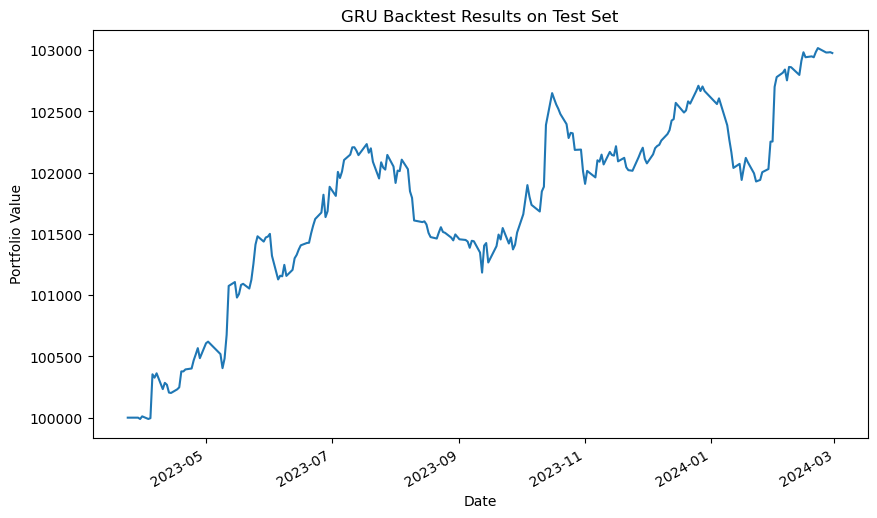

In [48]:
rtn,sp,mdd,gru_rtn_threshold_method_top1 = backtest_with_signals(
    generate_signals_threshold(test_res_gru, 0.368, -0.011, rolling_window = 5),
    # threshold: 
    # 0.368 : val_mean + 1.5*val_std;
    # -0.011 : val_mean - 1*val_std
    
    tpphrm_return, 
    initial_capital=100000, 
    capital_proportion=1, 
    trading_cost=0.0005,
    print_status = True)
plot_rtn(gru_rtn_threshold_method_top1,'GRU Backtest Results on Test Set')